In [9]:
import polars as pl
import numba as nb
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go

In [2]:
PATH = '/content/data'
dfs = [pl.read_parquet(os.path.join(PATH, x)) for x in os.listdir(PATH)]
merged = pl.concat(dfs[-2:]).lazy()

#### Queries

In [3]:
def scope_param(df: pl.LazyFrame, column: str="rpm_mapped") -> pl.LazyFrame:
    """
    takes one of the features of the genes and creates a new dataframe with the feature and target class

    Params:
        df (pl.DataFrame): TCGA-miRNA dataset
        column (str): property to built the dataframe around

    Returns:
        pl.DataFrame: polars DataFrame with target, unique case and value corresponding to each gene
    """
    scoped_df = df.pivot(index="uuid", columns="miRNA_ID", values=column)
    return scoped_df.join(df.select(pl.col(['uuid', 'project'])), on="uuid", how="left")

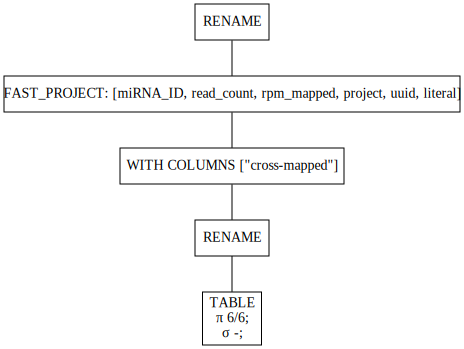

In [4]:
df = (
    merged
        .rename({ "reads_per_million_miRNA_mapped": "rpm_mapped" })
        .with_columns(
                pl.when(pl.col("cross-mapped") == "Y")
                    .then(pl.lit('1'))
                    .otherwise(pl.lit('0'))
                    .cast(pl.UInt8))
        .drop("cross-mapped")
        .rename({ "literal": "cross-map"})
)

df.show_graph(optimized=True)

In [5]:
df = df.collect(streaming=True).pipe(scope_param)
df.write_parquet("./df.parquet")

In [10]:
df = pl.scan_parquet("/content/df.parquet")

In [11]:
entropies = df.collect(streaming=True).select(pl.exclude(["project", "uuid"]).entropy())

In [12]:
rpm_genes = df.select(pl.exclude(["uuid", "project"]))
std_dev_df = rpm_genes.std()
mean_df = rpm_genes.mean()
std_dev = list(std_dev_df.collect(streaming=True).to_numpy())[0]
mean = list(mean_df.collect(streaming=True).to_numpy())[0]
entropy = list(entropies.to_numpy()[0])

In [16]:
expressed_genes = np.where(np.isnan(entropies.to_numpy()) == False)
expressed_genes[0].shape

(190,)

In [26]:
expressed_genes = np.array(rpm_genes.columns)[expressed_genes[1]]

In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=rpm_genes.columns, y=std_dev, name='std'))
fig.add_trace(go.Scatter(x=rpm_genes.columns, y=mean, name='mean'))
fig.add_trace(go.Scatter(x=rpm_genes.columns, y=entropy, name='entropy'))

fig.update_layout(
    title='Entropy, Mean and Standard Deviation of RPM count of miRNA Sequence',
    xaxis_title='miRNA ID',
    yaxis_title='mean/ std. deviation/ entropy',
    xaxis_tickangle=-45
)

fig.show()

In [32]:
df_rpm = df.select("uuid", "project", *list(expressed_genes)).collect(streaming=True)
df_rpm.write_parquet("/content/df_rpm.parquet")

df_rc = df.select("uuid", "project", *list(expressed_genes)).collect(streaming=True)
df_rc.write_parquet("/content/df_rc.parquet")

In [36]:
df_rpm.select(pl.exclude(["project", "uuid"])).describe()

describe,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103a-1,hsa-mir-103a-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1180,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,…,hsa-mir-491,hsa-mir-497,hsa-mir-500a,hsa-mir-501,hsa-mir-502,hsa-mir-505,hsa-mir-532,hsa-mir-542,hsa-mir-574,hsa-mir-576,hsa-mir-582,hsa-mir-584,hsa-mir-589,hsa-mir-590,hsa-mir-598,hsa-mir-625,hsa-mir-629,hsa-mir-652,hsa-mir-660,hsa-mir-664a,hsa-mir-671,hsa-mir-7-1,hsa-mir-708,hsa-mir-744,hsa-mir-766,hsa-mir-769,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-9-3,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,…,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6,1.933668e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",13670.143047,13635.917075,13701.953221,13702.831865,4004.180087,981.737787,2252.76032,7981.439062,8085.485738,1216.737059,1572.986433,8512.090721,9972.462143,10051.255498,10856.688033,10884.315588,29.155724,695.081732,95.917571,53941.572852,67132.862072,47.236869,1650.607272,1397.919932,1434.268224,5014.560463,20.362347,382.632127,116.721642,85.911576,46.700832,23.70605,13.920925,1779.920463,201.144518,49.968044,…,8.257127,32.307566,353.889998,68.450275,15.880868,58.993933,1250.043953,808.13627,88.784976,15.45444,149.071355,51.939902,63.956495,25.730572,74.05204,190.587084,101.315815,38.842045,60.235292,62.616741,11.180619,43.907716,210.11737,85.559714,10.116981,31.092455,4075.654832,4076.156598,4084.790191,6116.465608,5610.56748,270.159853,4982.3335,34.007509,74.334455,1378.798796,50211.549662
"""std""",8219.336536,8216.47408,8211.100841,9709.504057,3091.053954,466.124444,1709.621946,7965.495906,8067.949425,646.862431,1352.373909,8269.137984,7513.863141,7558.429196,6037.643554,6038.923472,60.920334,534.055225,54.749791,77831.542381,87886.982746,37.25304,1066.015926,1213.373032,1227.316522,3777.293341,20.135173,725.90515,85.933349,69.853945,30.146313,26.43252,10.144875,1518.765874,157.867148,63.497973,…,5.282873,31.85375,347.570481,75.911137,11.824369,47.469834,925.677736,919.013323,54.195223,13.216649,221.179405,50.994756,49.413598,18.832631,67.450877,215.03387,95.227788,34.739436,41.436585,44.316849,6.171631,42.198509,252.526732,52.28475,10.304956,23.174046,11267.287263,11266.858377,11290.936792,4222.361781,3923.633544,390.144912,4148.820466,33.194468,33.109276,1087.337371,27504.556055
"""min""",1077.080408,1108.4

In [45]:
means = df_.group_by('project').agg(pl.exclude(["project", "uuid"]).mean())
std_devs = pruned_df.group_by('project').agg(pl.exclude(["project", "uuid"]).std())

pruned_df.with_columns_seq(
    pl.col()
)

project,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103a-1,hsa-mir-103a-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1180,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,…,hsa-mir-491,hsa-mir-497,hsa-mir-500a,hsa-mir-501,hsa-mir-502,hsa-mir-505,hsa-mir-532,hsa-mir-542,hsa-mir-574,hsa-mir-576,hsa-mir-582,hsa-mir-584,hsa-mir-589,hsa-mir-590,hsa-mir-598,hsa-mir-625,hsa-mir-629,hsa-mir-652,hsa-mir-660,hsa-mir-664a,hsa-mir-671,hsa-mir-7-1,hsa-mir-708,hsa-mir-744,hsa-mir-766,hsa-mir-769,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-9-3,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""TCGA-THCA""",17277.888186,17249.631749,17287.089482,10335.800421,5407.352745,1121.716294,3042.317236,12013.730305,12164.046129,1187.640595,2587.005821,12923.879,14836.157091,14958.157594,12470.011241,12499.634709,7.16996,422.875237,98.194577,5304.025624,21140.108419,50.369243,2120.186257,2115.885312,2160.839361,6905.062478,15.017755,239.560075,91.859393,67.668368,42.279064,11.796996,11.751085,1085.01457,180.134469,23.704094,…,9.692119,22.366955,198.794598,31.900183,10.803932,34.998285,930.409473,1305.454364,96.870088,9.735002,64.546485,73.154212,58.51601,17.359273,109.903969,130.89188,91.595956,37.553454,61.140518,88.525104,9.967866,33.546773,187.819526,83.98167,6.397513,21.139268,39.049398,38.981195,39.190264,4712.794125,4294.359718,120.261024,3312.255695,17.040139,80.431602,1782.719082,49341.377064
"""TCGA-UCEC""",9469.968179,9428.792413,9528.099849,17622.765314,2370.591709,818.773337,1333.549848,3287.003151,3337.1828,1250.611468,392.454388,3375.840368,4310.097287,4338.588425,8978.440172,9003.744065,54.751783,1011.987399,93.266658,110565.91731,120678.110008,43.590126,1103.918475,562.057079,588.386458,2813.618118,26.584579,549.198117,145.666535,107.150511,51.848701,37.570697,16.447076,2588.937218,225.604638,80.544811,…,6.586495,43.880529,534.453694,111.002277,21.791491,86.929919,1622.16578,229.15331,79.372204,22.11307,247.476099,27.24198,70.290364,35.476526,32.312847,260.084869,112.631777,40.342238,59.181418,32.453952,12.592519,55.970034,236.076754,87.396889,14.447225,42.680059,8775.11337,8776.278698,8794.720212,7750.634725,7142.910413,444.673648,6926.655661,53.761101,67.236092,908.550548,51224.613761


In [ ]:
# normalize pruned df miRNA ID columns
pruned_df = pruned_df.